In [1]:
# !pip install shap

In [2]:
# !pip install pycaret

In [3]:
# !pip install ipywidgets

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
df_raw = pd.read_csv('E:\\2차 프로젝트 문서\\엑셀_한국산업안전보건공단_근로환경조사_20231231\\0721_1_data.csv', encoding='CP949')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 375 entries, id to comp_sizeb_r
dtypes: float64(130), int64(243), object(2)
memory usage: 42.8+ MB


In [6]:
df_raw.columns

Index(['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1',
       'earning2_r', 'wtime_r', 'woutside4_1',
       ...
       'ind2', 'occ', 'occ2', 'earning1_r', 'emp_con_period_r', 'wtime_con_r',
       'ptime_r', 'job_c1_r', 'comp_sizea_r', 'comp_sizeb_r'],
      dtype='object', length=375)

In [7]:
df_raw['burnout60'].unique()

array(['lv1', 'lv2', 'lv3'], dtype=object)

In [8]:
# 타겟 클래스번호 전처리
df_raw['burnout60'] = df_raw['burnout60'].replace("lv1", 1)
df_raw['burnout60'] = df_raw['burnout60'].replace("lv2", 2)
df_raw['burnout60'] = df_raw['burnout60'].replace("lv3", 3)
df_raw['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [9]:
df_raw['burnout60'] = df_raw['burnout60'].astype('category')
print(df_raw["burnout60"])

0        1
1        2
2        1
3        1
4        1
        ..
14951    1
14952    2
14953    1
14954    1
14955    1
Name: burnout60, Length: 14956, dtype: category
Categories (3, int64): [1, 2, 3]


In [10]:
df = df_raw.drop(['id', 'weng1', 'weng2', 'weng3', 'wsituation14', 'wwa2', 'sleep2', 'sleep3', 'weng4', 'weng5', 'wsituation1', 'wstat4', 'wsituation2', 'wsituation12', 'emp_manaqual1', 'wsituation10', 'wsituation9', 'occ', 'occ2', 'age'], axis = 1)

In [11]:
print("rows, cols:", df.shape)

rows, cols: (14956, 355)


In [12]:
from pycaret.classification import *
from sklearn.preprocessing import *
# import imblearn
setup_clf = setup(df, target = 'burnout60',
                  train_size = 0.8,
                  # ignore_features = ['pclass', 'adult_male', 'deck', 'embark_town', 'alive'],
                  # numeric_features = ['age','fare'],
                  # categorical_features = categories,
                  # encoding_method = None,
                  normalize = True,
                  normalize_method = 'zscore',
                  # remove_outliers = True,
                  feature_selection = True,
                  # feature_selection_method = 'classic',
                  # fix_imbalance = True,
                  # fix_imbalance_method = 'SMOTE',
                  fold=5,
                  n_jobs = - 1,
                  session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,burnout60
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(14956, 355)"
5,Transformed data shape,"(14956, 71)"
6,Transformed train set shape,"(11964, 71)"
7,Transformed test set shape,"(2992, 71)"
8,Numeric features,354
9,Rows with missing values,100.0%


In [13]:
best = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8686,0.8757,0.8686,0.8465,0.8503,0.4075,0.4291,0.8620
et,Extra Trees Classifier,0.8592,0.8671,0.8592,0.8243,0.8196,0.2549,0.3200,0.5870
rf,Random Forest Classifier,0.8602,0.8630,0.8602,0.8244,0.8215,0.2657,0.3284,0.6050
nb,Naive Bayes,0.7703,0.8319,0.7703,0.8367,0.7960,0.3427,0.3587,0.6710
knn,K Neighbors Classifier,0.8526,0.7675,0.8526,0.8137,0.8188,0.2587,0.3004,0.7130
dt,Decision Tree Classifier,0.7961,0.6528,0.7961,0.8004,0.7981,0.2640,0.2643,0.5130
dummy,Dummy Classifier,0.8421,0.5000,0.8421,0.7091,0.7699,0.0000,0.0000,0.5400
lr,Logistic Regression,0.8660,0.0000,0.8660,0.8400,0.8438,0.3775,0.4063,0.6870
svm,SVM - Linear Kernel,0.8556,0.0000,0.8556,0.8214,0.8257,0.3061,0.3427,0.5550
ridge,Ridge Classifier,0.8514,0.0000,0.8514,0.7882,0.7982,0.1548,0.2340,0.5270


#### 변수 중요도 확인

In [14]:
# 전체 데이터
X = df.drop(['burnout60'], axis = 1)
y = df['burnout60']

print("X 데이터: ", X.shape)
print("y 데이터: ", y.shape)

X 데이터:  (14956, 354)
y 데이터:  (14956,)


In [15]:
# 데이터 분할 = 훈련 데이터 / 테스트 데이터 = 7:3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
print("train 데이터: ", X_train.shape)
print("test 데이터: ", X_test.shape)

train 데이터:  (10469, 354)
test 데이터:  (4487, 354)


In [16]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# 매개변수 기본값 직접 확인해볼 것!
rf = RandomForestClassifier(n_jobs = -1, random_state=42)
scores = cross_validate(rf, X_train, y_train, return_train_score=True,
                        n_jobs = -1, cv = 10)

print(scores)

{'fit_time': array([1.21310544, 1.14179611, 1.14380407, 1.11297178, 1.17965364,
       1.09174395, 1.08974457, 1.07713223, 1.17965364, 1.19575191]), 'score_time': array([0.05096245, 0.07330966, 0.0713017 , 0.10213399, 0.05428338,
       0.12336183, 0.12336183, 0.13797355, 0.05428338, 0.05488443]), 'test_score': array([0.85100287, 0.86150907, 0.8443171 , 0.85100287, 0.85195798,
       0.85673352, 0.8548233 , 0.85004776, 0.86150907, 0.84703633]), 'train_score': array([0.99989387, 0.99978773, 0.99989387, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99989387, 1.        ])}


In [17]:
# 훈련 전체 데이터로 학습
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
f_imp_v = rf.feature_importances_
f_imp_v = pd.Series(f_imp_v, index = X.columns)
f_imp_v.sort_values(ascending = False).head(15)

wsituation8      0.021371
wsituation11     0.018987
wstat2           0.015876
emp_comp_ass1    0.014468
who1             0.014278
wsituation3      0.014265
wstat5           0.013808
wsituation13     0.013206
wstat1           0.012555
wsituation7      0.012255
wstat3           0.012132
who3             0.012105
emp_manaqual5    0.011791
emp_comp_ass6    0.010985
wsituation5      0.010635
dtype: float64

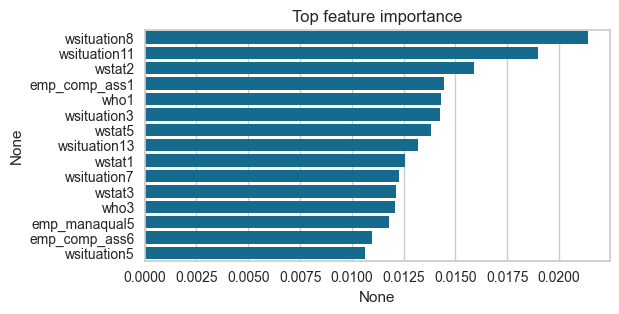

In [19]:
f_top = f_imp_v.sort_values(ascending = False).head(15)
plt.figure(figsize = (6, 3))
sns.barplot(x = f_top, y = f_top.index)
plt.title('Top feature importance')
plt.show()

#### SHAP

In [20]:
top_features = f_top.head(15).index.tolist()

In [21]:
# 클래스 이진으로 수정
df['burnout60'] = df['burnout60'].replace(2, 0)
df['burnout60'] = df['burnout60'].replace(1, 0)
df['burnout60'] = df['burnout60'].replace(3, 1)
df['burnout60']

0        0
1        0
2        0
3        0
4        0
        ..
14951    0
14952    0
14953    0
14954    0
14955    0
Name: burnout60, Length: 14956, dtype: category
Categories (2, int64): [0, 1]

In [22]:
# 선택한 변수를 활용해서 다시 모델에 넣기

# 전체 데이터
X_new = X[top_features]
y = df['burnout60']

print("X 데이터: ", X.shape)
print("y 데이터: ", y.shape)

X 데이터:  (14956, 354)
y 데이터:  (14956,)


In [23]:
# 데이터 분할 = 훈련 데이터 / 테스트 데이터 = 7:3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
print("train 데이터: ", X_train.shape)
print("test 데이터: ", X_test.shape)

train 데이터:  (10469, 15)
test 데이터:  (4487, 15)


#### LightGBM

In [24]:
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score=True,
                        n_jobs = -1, cv = 10)
print(scores)

{'fit_time': array([0.74764538, 0.76456022, 0.75817442, 0.78690791, 0.796664  ,
       0.77876186, 0.76017809, 0.91900182, 0.75577903, 0.92836595]), 'score_time': array([0.0045197 , 0.00819206, 0.006778  , 0.00400567, 0.00200415,
       0.00174403, 0.00695801, 0.00374722, 0.00400686, 0.00303769]), 'test_score': array([0.97898758, 0.97421203, 0.98185291, 0.98185291, 0.97994269,
       0.97612225, 0.98376313, 0.97516714, 0.97803247, 0.97992352]), 'train_score': array([0.99734664, 0.99777117, 0.9972405 , 0.99777117, 0.99745277,
       0.9975589 , 0.99766504, 0.99713437, 0.99766504, 0.99702855])}


In [25]:
# 훈련 전체 데이터로 학습
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 232, number of negative: 10237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 10469, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022161 -> initscore=-3.787027
[LightGBM] [Info] Start training from score -3.787027


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [26]:
final_model = lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 232, number of negative: 10237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 10469, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022161 -> initscore=-3.787027
[LightGBM] [Info] Start training from score -3.787027


In [27]:
import shap
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)
shap_values

.values =
array([[ 1.01580316,  0.79862143,  0.11939066, ...,  0.25471429,
         0.04495375,  0.26121579],
       [-0.33457425, -0.16108052,  0.45987065, ..., -0.07647157,
         0.08073824, -0.16234737],
       [-0.45706433, -0.45963168, -0.31258556, ...,  0.01208952,
         0.01612268, -0.13751276],
       ...,
       [-0.4983585 , -0.53693621, -0.12655668, ...,  0.10114724,
        -0.02100368,  0.04852211],
       [ 0.54577357, -0.6090037 , -1.35405379, ..., -0.05200644,
        -1.24166582,  0.02530906],
       [-0.29575623,  0.00665169, -0.06952269, ...,  0.06500951,
         0.0213823 ,  0.48028006]])

.base_values =
array([-7.63112552, -7.63112552, -7.63112552, ..., -7.63112552,
       -7.63112552, -7.63112552])

.data =
array([[3, 3, 4, ..., 2, 2, 2],
       [2, 2, 3, ..., 2, 2, 3],
       [2, 2, 4, ..., 2, 2, 3],
       ...,
       [2, 1, 2, ..., 3, 2, 3],
       [3, 1, 1, ..., 2, 1, 2],
       [2, 1, 2, ..., 4, 4, 5]], dtype=int64)

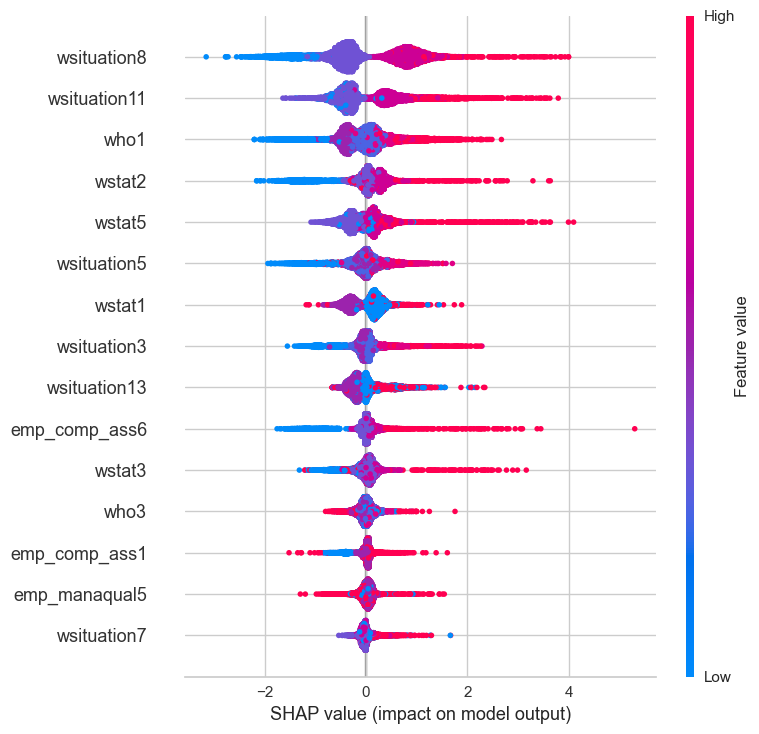

In [28]:
# 해석 교수님 피드백 받기
shap.summary_plot(shap_values, X_train)

In [29]:
print(shap_values.shape)

(10469, 15)


In [30]:
shap_values_class2 = shap_values[:, :, 2]
print(shap_values_class2.shape)

IndexError: too many indices for array

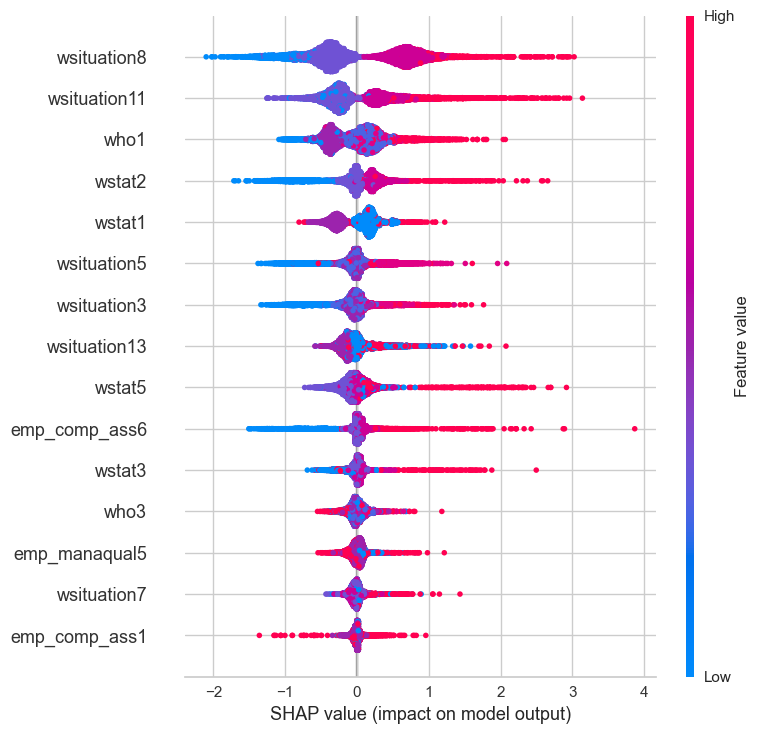

In [ ]:
shap.summary_plot(shap_values_class2, X_train)